tgb - 4/20/2020 - Adapting Ankitesh's climate-invariant training notebook for hyperparameter optimization by David Walling. 

In [1]:
import sys
sys.path.insert(1,"/home1/07064/tg863631/anaconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages") #work around for h5py
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
from tensorflow import math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_probability as tfp
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
# import cartopy.crs as ccrs
import matplotlib.ticker as mticker
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
# from climate_invariant import *
from tensorflow.keras import layers
import datetime
from climate_invariant_utils import *
import yaml


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog


## Global Variables

In [25]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/oasis/scratch/comet/ankitesh/temp_project/data/sp8fbp_minus4k.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [26]:
TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/CRHData/'
path = '/home/ankitesh/CBrain_project/CBRAIN-CAM/cbrain/'
path_hyam = 'hyam_hybm.pkl'

hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)
scale_dict = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')


In [27]:
inter_dim_size = 40 #required for interpolation layer

In [5]:
class DataGeneratorClimInv(DataGenerator):
    
    def __init__(self, data_fn, input_vars, output_vars,
             norm_fn=None, input_transform=None, output_transform=None,
             batch_size=1024, shuffle=True, xarray=False, var_cut_off=None, 
             rh_trans=True,t2tns_trans=True,
             lhflx_trans=True,
             scaling=True,interpolate=True,
             hyam=None,hybm=None,                 
             inp_subRH=None,inp_divRH=None,
             inp_subTNS=None,inp_divTNS=None,
             lev=None, interm_size=40,
             lower_lim=6,
             is_continous=True,Tnot=5,
                mode='train'):
        
        self.scaling = scaling
        self.interpolate = interpolate
        self.rh_trans = rh_trans
        self.t2tns_trans = t2tns_trans
        self.lhflx_trans = lhflx_trans
        self.inp_shape = 64
        self.mode=mode
        super().__init__(data_fn, input_vars,output_vars,norm_fn,input_transform,output_transform,
                        batch_size,shuffle,xarray,var_cut_off) ## call the base data generator
        self.inp_sub = self.input_transform.sub
        self.inp_div = self.input_transform.div
        if rh_trans:
            self.qv2rhLayer = QV2RHNumpy(self.inp_sub,self.inp_div,inp_subRH,inp_divRH,hyam,hybm)
        
        if lhflx_trans:
            self.lhflxLayer = LhflxTransNumpy(self.inp_sub,self.inp_div,hyam,hybm)
            
        if t2tns_trans:
            self.t2tnsLayer = T2TmTNSNumpy(self.inp_sub,self.inp_div,inp_subTNS,inp_divTNS,hyam,hybm)
            
        if scaling:
            self.scalingLayer = ScalingNumpy(hyam,hybm)
            self.inp_shape += 1
                    
        if interpolate:
            self.interpLayer = InterpolationNumpy(lev,is_continous,Tnot,lower_lim,interm_size)
            self.inp_shape += interm_size*2 + 4 + 30 ## 4 same as 60-64 and 30 for lev_tilde.size
        
            
        
    def __getitem__(self, index):
        # Compute start and end indices for batch
        start_idx = index * self.batch_size
        end_idx = start_idx + self.batch_size

        # Grab batch from data
        batch = self.data_ds['vars'][start_idx:end_idx]

        # Split into inputs and outputs
        X = batch[:, self.input_idxs]
        Y = batch[:, self.output_idxs]
        # Normalize
        X_norm = self.input_transform.transform(X)
        Y = self.output_transform.transform(Y)
        X_result = X_norm
        
        if self.rh_trans:
            X_result = self.qv2rhLayer.process(X_result) 
            
        if self.lhflx_trans:
            X_result = self.lhflxLayer.process(X_result)
            
        if self.t2tns_trans:
            X_result = self.t2tnsLayer.process(X_result)
        
        if self.scaling:
            scalings = self.scalingLayer.process(X) 
            X_result = np.hstack((X_result,scalings))
        
        if self.interpolate:
            interpolated = self.interpLayer.process(X,X_result)
            X_result = np.hstack((X_result,interpolated))
            

        if self.mode=='val':
            return xr.DataArray(X_result), xr.DataArray(Y)
        return X_result,Y
    
    ##transforms the input data into the required format, take the unnormalized dataset
    def transform(self,X):
        X_norm = self.input_transform.transform(X)
        X_result = X_norm
        
        if self.rh_trans:
            X_result = self.qv2rhLayer.process(X_result)  
        
        if self.lhflx_trans:
            X_result = self.lhflxLayer.process(X_result)

        if self.t2tns_trans:
            X_result = self.t2tnsLayer.process(X_result)
        
        if self.scaling:
            scalings = self.scalingLayer.process(X) 
            X_result = np.hstack((X_result,scalings))
        
        if self.interpolate:
            interpolated = self.interpLayer.process(X,X_result)
            X_result = np.hstack((X_result,interpolated))
            

        return X_result

## Data Generators

In [6]:
geography = False # True for real-geography dataset, false otherwise

### Choose between aquaplanet and realistic geography here

In [7]:
if geography: path = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/geography/'
else: path = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'
    
if geography: TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/CRHData/'
else: TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/geography/'

### Data Generator using RH

In [8]:
scale_dict_RH = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%
scale_dict_RH['PTTEND']=scale_dict_RH['TPHYSTND']
scale_dict_RH['PTEQ']=scale_dict_RH['PHQ']

in_vars_RH = ['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if geography: out_vars_RH = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']
else: out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

TRAINFILE_RH = 'CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'CI_RH_M4K_NORM_norm.nc'
VALIDFILE_RH = 'CI_RH_M4K_NORM_valid.nc'

In [9]:
train_gen_RH = DataGenerator(
    data_fn = path+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = path+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True
)

#### For positve sepearation (required since we are going to use scaling)

In [10]:
TRAINFILE_RH = 'PosCRH_CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'PosCRH_CI_RH_M4K_NORM_norm.nc'

train_gen_RH_pos = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = TRAINDIR+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True
)

#### For negative sepearation

In [11]:
TRAINFILE_RH = 'NegCRH_CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'NegCRH_CI_RH_M4K_NORM_norm.nc'

train_gen_RH_neg = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = TRAINDIR+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True
)

### Data Generator using TNS

In [12]:
in_vars = ['QBP','TfromNS','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = out_vars_RH
# if geography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']
# else: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

TRAINFILE_TNS = 'CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'CI_TNS_M4K_NORM_norm.nc'
VALIDFILE_TNS = 'CI_TNS_M4K_NORM_valid.nc'

In [13]:
train_gen_TNS = DataGenerator(
    data_fn = path+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

#### For positive 

In [14]:
TRAINFILE_TNS = 'PosCRH_CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'PosCRH_CI_TNS_M4K_NORM_norm.nc'

train_gen_TNS_pos = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

#### For negative 

In [15]:
TRAINFILE_TNS = 'NegCRH_CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'NegCRH_CI_TNS_M4K_NORM_norm.nc'

train_gen_TNS_neg = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

### Data Generator Combined 

In [16]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
#out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [17]:
## this won't be used just to show we can use it overall
TRAINFILE = 'CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'CI_SP_M4K_valid.nc'

train_gen = DataGeneratorClimInv(
    data_fn = path+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div
)

valid_gen = DataGeneratorClimInv(
    data_fn = path+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div
)

In [18]:
train_gen[0][0].shape

(1024, 179)

#### For positive

In [19]:
TRAINFILE = 'PosCRH_CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'PosCRH_CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'PosCRH_CI_SP_M4K_valid.nc'

train_gen_pos = DataGeneratorClimInv(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH_pos.input_transform.sub, inp_divRH=train_gen_RH_pos.input_transform.div,
    inp_subTNS=train_gen_TNS_pos.input_transform.sub,inp_divTNS=train_gen_TNS_pos.input_transform.div,
    is_continous=True
)

valid_gen_pos = DataGeneratorClimInv(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH_pos.input_transform.sub, inp_divRH=train_gen_RH_pos.input_transform.div,
    inp_subTNS=train_gen_TNS_pos.input_transform.sub,inp_divTNS=train_gen_TNS_pos.input_transform.div,
    is_continous=True
)

In [20]:
train_gen_pos[0][0].shape

(1024, 179)

#### For Negative

In [21]:
TRAINFILE = 'NegCRH_CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'NegCRH_CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'NegCRH_CI_SP_M4K_valid.nc'

### we don't scale this network
train_gen_neg = DataGeneratorClimInv(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH_neg.input_transform.sub, inp_divRH=train_gen_RH_neg.input_transform.div,
    inp_subTNS=train_gen_TNS_neg.input_transform.sub,inp_divTNS=train_gen_TNS_neg.input_transform.div,
    is_continous=True,
    scaling=False
)

valid_gen_neg = DataGeneratorClimInv(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH_neg.input_transform.sub, inp_divRH=train_gen_RH_neg.input_transform.div,
    inp_subTNS=train_gen_TNS_neg.input_transform.sub,inp_divTNS=train_gen_TNS_neg.input_transform.div,
    is_continous=True,
    scaling=False
)

In [22]:
train_gen_neg[0][0].shape

(1024, 178)

## Building the Model

### For Positive

In [27]:
inp = Input(shape=(179,)) ## input after rh and tns transformation
offset = 65
inp_TNS = inp[:,offset:offset+2*inter_dim_size+4]
offset = offset+2*inter_dim_size+4
lev_tilde_before = inp[:,offset:offset+30]
offset = offset+30

densout = Dense(128, activation='linear')(inp_TNS)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
denseout = Dense(2*inter_dim_size+4, activation='linear')(densout)
lev_original_out = reverseInterpLayer(inter_dim_size)([denseout,lev_tilde_before])
out = ScaleOp(OpType.PWA.value,
              inp_subQ=train_gen_pos.input_transform.sub, 
              inp_divQ=train_gen_pos.input_transform.div,
              )([inp,lev_original_out])
model_pos = tf.keras.models.Model(inp, out)

Instructions for updating:
Colocations handled automatically by placer.


/home/tbeucler/pkg/miniconda3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/tbeucler/pkg/miniconda3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/tbeucler/pkg/miniconda3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/tbeucler/pkg/miniconda3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/tbeucler/pkg/miniconda3/lib/python3.6/site-packages/numpy/lib/type

AttributeError: module 'tensorflow_probability.python.math' has no attribute 'batch_interp_regular_1d_grid'

In [25]:
model_pos.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 179)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 84)]         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          10880       tf_op_layer_strided_slice[0][0]  
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128)          0           dense[0][0]                      
______________________________________________________________________________________________

In [29]:
model_pos.compile(tf.keras.optimizers.Adam(), loss=mse)

In [30]:
# Where to save the model
path_HDF5 = '/oasis/scratch/comet/tbeucler/temp_project/CBRAIN_models/'
save_name = 'CI_Pos_temp'

In [31]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
Nep = 25
model_pos.fit_generator(train_gen_pos, epochs=Nep, validation_data=valid_gen_pos,\
              callbacks=[earlyStopping, mcp_save])

Epoch 1/25
Instructions for updating:
Use tf.identity instead.
9144/9144 [==============================] - 1766s 193ms/step - loss: 623.9487 - val_loss: 538.1217
Epoch 2/25
 610/9144 [=>............................] - ETA: 16:30 - loss: 558.1734

KeyboardInterrupt: 

### For Negative

In [22]:
inp = Input(shape=(178,)) ## input after rh and tns transformation
offset = 64
inp_TNS = inp[:,offset:offset+2*inter_dim_size+4]
offset = offset+2*inter_dim_size+4
lev_tilde_before = inp[:,offset:offset+30]
offset = offset+30

densout = Dense(128, activation='linear')(inp_TNS)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
denseout = Dense(2*inter_dim_size+4, activation='linear')(densout)
lev_original_out = reverseInterpLayer(inter_dim_size)([denseout,lev_tilde_before])

model_neg = tf.keras.models.Model(inp, lev_original_out)

In [23]:
model_neg.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 178)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 84)]         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          10880       tf_op_layer_strided_slice[0][0]  
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128)          0           dense[0][0]                      
______________________________________________________________________________________________

In [24]:
model_neg.compile(tf.keras.optimizers.Adam(), loss=mse)

In [28]:
# Where to save the model
path_HDF5 = '/oasis/scratch/comet/tbeucler/temp_project/CBRAIN_models/'
save_name = 'CI_Neg_temp'

In [29]:
path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/Comnined/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')


In [ ]:
Nep = 10
model_neg.fit_generator(train_gen_neg, epochs=Nep, validation_data=valid_gen_neg,\
              callbacks=[earlyStopping, mcp_save])

Epoch 1/10
 3268/32231 [==>...........................] - ETA: 1:32:07 - loss: 315.9958

## Example of how to combine positive and negative NNs to make predictions

### Test: Load `pb` models

In [23]:
pathBF = '/oasis/scratch/comet/tbeucler/temp_project/DavidW_models/BF_Aquaplanet/'

In [24]:
BF26 = tf.keras.models.load_model(pathBF+'26')
BF33 = tf.keras.models.load_model(pathBF+'33')
BF25 = tf.keras.models.load_model(pathBF+'25')
BF28 = tf.keras.models.load_model(pathBF+'28')
BF27 = tf.keras.models.load_model(pathBF+'27')

### Define how to load climate-invariant NN

In [29]:
class ClimateNet:
    def __init__(self,dict_lay,data_fn,config_fn,
             lev,hyam,hybm,TRAINDIR,
             nlat, nlon, nlev, ntime,
             inp_subRH,inp_divRH,
             inp_subTNS,inp_divTNS,
             rh_trans=False,t2tns_trans=False,
             lhflx_trans=False,
             scaling=False,interpolate=False,
             model=None,
             pos_model=None,neg_model=None,
             #this can be none if no scaling is present
             train_gen_RH_pos=None,train_gen_RH_neg=None,
             train_gen_TNS_pos=None,train_gen_TNS_neg=None,
                ):


        with open(config_fn, 'r') as f:
            config = yaml.load(f)
        out_scale_dict = load_pickle(config['output_dict'])
        ngeo = nlat * nlon
        in_vars = config['inputs']
        out_vars = config['outputs']

        self.valid_gen = DataGeneratorClimInv(
                data_fn = data_fn,
                input_vars=in_vars,
                output_vars=out_vars,
                norm_fn=config['data_dir'] + config['norm_fn'],
                input_transform=(config['input_sub'], config['input_div']),
                output_transform=out_scale_dict,
                batch_size=ngeo,
                shuffle=False,
                xarray=True,
                var_cut_off=config['var_cut_off'] if 'var_cut_off' in config.keys() else None,
                rh_trans = rh_trans,t2tns_trans = t2tns_trans,
                lhflx_trans = lhflx_trans,
                scaling = scaling,
                lev=lev,interpolate = interpolate,
                hyam=hyam,hybm=hybm,
                inp_subRH=inp_subRH, inp_divRH=inp_divRH,
                inp_subTNS=inp_subTNS,inp_divTNS=inp_divTNS,
                mode='val'

        )

        self.rh_trans = rh_trans
        self.t2tns_trans = t2tns_trans
        self.lhflx_trans = lhflx_trans
        self.scaling = scaling
        self.interpolate = interpolate
        self.subQ,self.divQ = np.array(self.valid_gen.input_transform.sub),np.array(self.valid_gen.input_transform.div)

        if model != None:
            self.model = load_model(model,custom_objects=dict_lay)

        if scaling:
            self.pos_model = load_model(pos_model,custom_objects=dict_lay)
            self.neg_model = load_model(neg_model,custom_objects=dict_lay)

            #just for the norm values
            self.pos_data_gen = DataGeneratorClimInv(
                                data_fn = TRAINDIR+'PosCRH_CI_SP_M4K_train_shuffle.nc',
                                input_vars = in_vars,
                                output_vars = out_vars,
                                norm_fn = TRAINDIR+'PosCRH_CI_SP_M4K_NORM_norm.nc',
                                input_transform = ('mean', 'maxrs'),
                                output_transform = out_scale_dict,
                                batch_size=1024,
                                shuffle=True,
                                lev=lev,
                                hyam=hyam,hybm=hybm,
                                inp_subRH=train_gen_RH_pos.input_transform.sub, inp_divRH=train_gen_RH_pos.input_transform.div,
                                inp_subTNS=train_gen_TNS_pos.input_transform.sub,inp_divTNS=train_gen_TNS_pos.input_transform.div,
                                is_continous=True,
                                scaling=True,
                                interpolate=interpolate,
                                rh_trans=rh_trans,
                                t2tns_trans=t2tns_trans,
                                lhflx_trans=lhflx_trans
                            )

            self.neg_data_gen = DataGeneratorClimInv(
                                data_fn = TRAINDIR+'NegCRH_CI_SP_M4K_train_shuffle.nc',
                                input_vars = in_vars,
                                output_vars = out_vars,
                                norm_fn = TRAINDIR+'NegCRH_CI_SP_M4K_NORM_norm.nc',
                                input_transform = ('mean', 'maxrs'),
                                output_transform = out_scale_dict,
                                batch_size=1024,
                                shuffle=True,
                                lev=lev,
                                hyam=hyam,hybm=hybm,
                                inp_subRH=train_gen_RH_neg.input_transform.sub, inp_divRH=train_gen_RH_neg.input_transform.div,
                                inp_subTNS=train_gen_TNS_neg.input_transform.sub,inp_divTNS=train_gen_TNS_neg.input_transform.div,
                                is_continous=True,
                                interpolate=interpolate,
                                scaling=False,
                                rh_trans=rh_trans,
                                t2tns_trans=t2tns_trans,
                                lhflx_trans=lhflx_trans
                            )


    def reorder(self,op_pos,op_neg,mask):
        op = []
        pos_i=0
        neg_i = 0
        for m in mask:
            if m:
                op.append(op_pos[pos_i])
                pos_i += 1
            else:
                op.append(op_neg[neg_i])
                neg_i += 1
        return np.array(op)


    def predict_on_batch(self,inp):
        #inp = batch x 179
        inp_de = inp*self.divQ+self.subQ
        if not self.scaling:
            inp_pred = self.valid_gen.transform(inp_de)
            return self.model.predict_on_batch(inp_pred)

        mask = ScalingNumpy(hyam,hybm).crh(inp_de)> 0.8
        pos_inp = inp[mask]
        neg_inp = inp[np.logical_not(mask)]
        ### for positive
        pos_inp = pos_inp*self.divQ + self.subQ
        pos_inp = self.pos_data_gen.transform(pos_inp)
        op_pos = self.pos_model.predict_on_batch(pos_inp)
        neg_inp = neg_inp*self.divQ + self.subQ
        neg_inp = self.neg_data_gen.transform(neg_inp)
        op_neg = self.neg_model.predict_on_batch(neg_inp)
        op = self.reorder(np.array(op_pos),np.array(op_neg),mask)
        return op

    ##just for network is scaling is present
    def predict_on_batch_seperate(self,inp):
        if self.scaling==False:
            raise("Scaling is not present in this model")

        inp_de = inp*self.divQ + self.subQ
        mask = ScalingNumpy(hyam,hybm).crh(inp_de)> 0.8
        pos_inp = inp[mask]
        neg_inp = inp[np.logical_not(mask)]

        pos_inp = pos_inp*self.divQ + self.subQ
        pos_inp = self.pos_data_gen.transform(pos_inp)
        neg_inp = neg_inp*self.divQ + self.subQ
        neg_inp = self.neg_data_gen.transform(neg_inp)

        op_pos = self.pos_model.predict_on_batch(pos_inp)
        op_neg = self.neg_model.predict_on_batch(neg_inp)

        return mask,op_pos,op_neg

In [30]:
# def load_climate_model(dict_lay,config_fn,data_fn,lev,hyam,hybm,TRAINDIR,
#                        inp_subRH,inp_divRH,
#                        inp_subTNS,inp_divTNS,
#                        nlat=64, nlon=128, nlev=30, ntime=48,
#                         rh_trans=False,t2tns_trans=False,
#                         lhflx_trans=False,
#                         scaling=False,interpolate=False,
#                         model=None,
#                         pos_model=None,neg_model=None):
    
    
    
#     obj = ClimateNet(dict_lay,data_fn,config_fn,
#                      lev,hyam,hybm,TRAINDIR,
#                      nlat, nlon, nlev, ntime,
#                      inp_subRH,inp_divRH,
#                      inp_subTNS,inp_divTNS,
#                     rh_trans=rh_trans,t2tns_trans=t2tns_trans,
#                     lhflx_trans=lhflx_trans, scaling=scaling,
#                     interpolate=interpolate,
#                     model = model,
#                     pos_model=pos_model,neg_model=neg_model)
#     return obj

tgb - 7/7/2020 - Adapting from [https://github.com/ankitesh97/CBRAIN-CAM/blob/climate_invariant_pull_request/cbrain/climate_invariant.py] instead

In [31]:
def load_climate_model(dict_lay,config_fn,data_fn,lev,hyam,hybm,TRAINDIR,
                       inp_subRH,inp_divRH,
                       inp_subTNS,inp_divTNS,
                       nlat=64, nlon=128, nlev=30, ntime=48,
                        rh_trans=False,t2tns_trans=False,
                        lhflx_trans=False,
                        scaling=False,interpolate=False,
                        model=None,
                        pos_model=None,neg_model=None,
                        train_gen_RH_pos=None,train_gen_RH_neg=None,
                        train_gen_TNS_pos=None,train_gen_TNS_neg=None):

    obj = ClimateNet(dict_lay,data_fn,config_fn,
                     lev,hyam,hybm,TRAINDIR,
                     nlat, nlon, nlev, ntime,
                     inp_subRH,inp_divRH,
                     inp_subTNS,inp_divTNS,
                    rh_trans=rh_trans,t2tns_trans=t2tns_trans,
                    lhflx_trans=lhflx_trans, scaling=scaling,
                    interpolate=interpolate,
                    model = model,
                    pos_model=pos_model,neg_model=neg_model,
                    train_gen_RH_pos=train_gen_RH_pos,train_gen_RH_neg=train_gen_RH_neg,
                    train_gen_TNS_pos=train_gen_TNS_pos,train_gen_TNS_neg=train_gen_TNS_neg)
    return obj

### Models' paths

In [35]:
config_file = 'CI_SP_M4K_CONFIG.yml' # Configuration file
if geography: data_file = ['geography/CI_SP_M4K_valid.nc','geography/CI_SP_P4K_valid.nc']  # Validation/test data sets
else: data_file = ['CI_SP_M4K_valid.nc','CI_SP_P4K_valid.nc']
# NNarray = ['RH_TNS_LH_ScalingPos_Interp_Geography.hdf5*RH_TNS_LH_ScalingNeg_Interp_Geography.hdf5',\
#           'RH_TNS_LH_ScalePos_Interp.hdf5*RH_TNS_LH_ScaleNeg_Interp.hdf5'] # NN to evaluate 
#NNarray = ['RH_TNS_LH_ScalePos_Interp.hdf5*RH_TNS_LH_ScaleNeg_Interp.hdf5']
#NNarray = ['RH_TNS_LHQsatScalePos.hdf5*RH_TNS_LHQsatScaleNeg.hdf5']
#NNarray = ['BF.hdf5']
#NNname = ['NN_Comb_geo','NN_Comb_aqua'] # Name of NNs for plotting
NNarray = ['BF.hdf5','pb'+pathBF+'26','pb'+pathBF+'33','pb'+pathBF+'25','pb'+pathBF+'28','pb'+pathBF+'27']
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH,
           'reverseInterpLayer':reverseInterpLayer,'ScaleOp':ScaleOp}
path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/'

In [36]:
# Indices of different variables
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(30,60)

### Build models' diagnostics object

In [39]:
#define default values

NN = {}; md = {};
#%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    
    rh_trans=False
    t2tns_trans=False
    lhflx_trans=False
    scaling=False
    interpolate=False
    model = path
    pos_model=None
    neg_model=None
    if 'RH' in NNs:
        rh_trans=True
    if 'TNS' in NNs:
        t2tns_trans=True
    if 'LH' in NNs:
        lhflx_trans=True
        
    if 'Scal' in NNs:
        pos,neg = NNs.split('*')
        pos_model = path_HDF5+pos
        neg_model = path_HDF5+neg
        model = None
        scaling=True
    if 'Interp' in NNs or 'Vert' in NNs:
        interpolate=True
        
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        
        if 'pb' in NNs:
            NN[NNs] = tf.keras.models.load_model(NNs[2:])
        else:
            NN[NNs] = load_climate_model(dict_lay,'/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                         '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data,
                                         lev=lev,hyam=hyam,hybm=hybm,TRAINDIR=TRAINDIR,
                                         inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
                                         inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
                                         rh_trans=rh_trans,t2tns_trans=t2tns_trans,
                                         lhflx_trans=lhflx_trans,scaling=scaling,interpolate=interpolate,
                                         model=model,pos_model=pos_model,neg_model=neg_model,
                                          train_gen_RH_pos=train_gen_RH_pos,train_gen_RH_neg=train_gen_RH_neg,
                                            train_gen_TNS_pos=train_gen_TNS_pos,train_gen_TNS_neg=train_gen_TNS_neg  )
        
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                                '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)

NN name is  BF.hdf5
data name is  CI_SP_M4K_valid.nc


/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:19: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/tbeucler/pkg/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:19: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


data name is  CI_SP_P4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  pb/oasis/scratch/comet/tbeucler/temp_project/DavidW_models/BF_Aquaplanet/26
data name is  CI_SP_M4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  pb/oasis/scratch/comet/tbeucler/temp_project/DavidW_models/BF_Aquaplanet/33
data name is  CI_SP_M4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  pb/oasis/scratch/comet/tbeucler/temp_project/DavidW_models/BF_Aquaplanet/25
data name is  CI_SP_M4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  pb/oasis/scratch/comet/tbeucler/temp_project/DavidW_models/BF_Aquaplanet/28
data name is  CI_SP_M4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  pb/oasis/scratch/comet/tbeucler/temp_project/DavidW_models/BF_Aquaplanet/27
data name is  CI_SP_M4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


### Global Mean-Squared error

In [45]:
Nt = 10
t_random = np.random.choice(np.linspace(0,1691,1692),size=((Nt,)),replace=False).astype('int')

In [46]:
MSE = {}
VAR = {}
diagno = {}
diagno['truth'] = {}
diagno['pred'] = {}

for iar,itime in enumerate(t_random):
    print('iar=',iar,'/',Nt-1,' & itime',itime,end="\r")
    for i,NNs in enumerate(NNarray):
        if iar==0: MSE[NNs] = {}; VAR[NNs] = {}
        for j,data in enumerate(data_file):

            inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]

            t_geo = md[NNs][data[6:-3]].reshape_ngeo(truth)[:,:,:]
            p_geo = md[NNs][data[6:-3]].reshape_ngeo(p.numpy())[:,:,:]

            if iar==0: 
                MSE[NNs][data[6:-3]] = np.mean((t_geo-p_geo)**2,axis=(1,2))
                VAR[NNs][data[6:-3]] = np.var(p_geo,axis=(1,2))
            else: 
                MSE[NNs][data[6:-3]] = np.concatenate((MSE[NNs][data[6:-3]],
                                                       np.mean((t_geo-p_geo)**2,axis=(1,2))),axis=0)
                VAR[NNs][data[6:-3]] = np.concatenate((VAR[NNs][data[6:-3]],
                                                       np.var(p_geo,axis=(1,2))),axis=0)

tgb - 7/9/2020 - Reporting to check that climate invariant NN works globally

In [47]:
for i,NNs in enumerate(NNarray):
    print(NNs)
    #if iar==0: MSE[NNs] = {}; VAR[NNs] = {}
    for j,data in enumerate(data_file):
        print(data,MSE[NNs][data[6:-3]].mean())
    print('\n')

BF.hdf5
CI_SP_M4K_valid.nc 340.51074
CI_SP_P4K_valid.nc 15524.823


pb/oasis/scratch/comet/tbeucler/temp_project/DavidW_models/BF_Aquaplanet/26
CI_SP_M4K_valid.nc 355.5851
CI_SP_P4K_valid.nc 8834.371


pb/oasis/scratch/comet/tbeucler/temp_project/DavidW_models/BF_Aquaplanet/33
CI_SP_M4K_valid.nc 344.25626
CI_SP_P4K_valid.nc 12408.722


pb/oasis/scratch/comet/tbeucler/temp_project/DavidW_models/BF_Aquaplanet/25
CI_SP_M4K_valid.nc 359.8221
CI_SP_P4K_valid.nc 8721.895


pb/oasis/scratch/comet/tbeucler/temp_project/DavidW_models/BF_Aquaplanet/28
CI_SP_M4K_valid.nc 351.95697
CI_SP_P4K_valid.nc 10823.705


pb/oasis/scratch/comet/tbeucler/temp_project/DavidW_models/BF_Aquaplanet/27
CI_SP_M4K_valid.nc 364.23618
CI_SP_P4K_valid.nc 13007.865




In [90]:
print(NNs)
for j,data in enumerate(data_file):
    print(data,MSE[NNs][data[6:-3]].mean())

BF.hdf5
CI_SP_M4K_valid.nc 338.84238
CI_SP_P4K_valid.nc 13835.135


In [82]:
print(NNs)
for j,data in enumerate(data_file):
    print(data,MSE[NNs][data[6:-3]].mean())

RH.hdf5
CI_SP_M4K_valid.nc 337.4395
CI_SP_P4K_valid.nc 883.7199


In [76]:
print(NNs)
for j,data in enumerate(data_file):
    print(data,MSE[NNs][data[6:-3]].mean())

RH_TNS.hdf5
CI_SP_M4K_valid.nc 341.198
CI_SP_P4K_valid.nc 1033.0723


In [70]:
print(NNs)
for j,data in enumerate(data_file):
    print(data,MSE[NNs][data[6:-3]].mean())

RH_TNS_LH.hdf5
CI_SP_M4K_valid.nc 359.31427
CI_SP_P4K_valid.nc 1092.0828


In [63]:
print(NNs)
for j,data in enumerate(data_file):
    print(data,MSE[NNs][data[6:-3]].mean())

RH_TNS_LHQsatScalePos.hdf5*RH_TNS_LHQsatScaleNeg.hdf5
CI_SP_M4K_valid.nc 1009.2324
CI_SP_P4K_valid.nc 1509.0775


In [53]:
print(NNs)
for j,data in enumerate(data_file):
    print(data,MSE[NNs][data[6:-3]].mean())

RH_TNS_LH_ScalePos_Interp.hdf5*RH_TNS_LH_ScaleNeg_Interp.hdf5
CI_SP_M4K_valid.nc 774.1818
CI_SP_P4K_valid.nc 1414.9604


### Mean squared error by latitude

In [34]:
Nt = 10
t_random = np.random.choice(np.linspace(0,1691,1692),size=((Nt,)),replace=False).astype('int')

In [35]:
MSE = {}
VAR = {}
diagno = {}
diagno['truth'] = {}
diagno['pred'] = {}

for iar,itime in enumerate(t_random):
    print('iar=',iar,'/',Nt-1,' & itime',itime,end="\r")
    for i,NNs in enumerate(NNarray):
        if iar==0: MSE[NNs] = {}; VAR[NNs] = {}

        inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
        
        t_geo = md[NNs][data[6:-3]].reshape_ngeo(truth)[:,:,:]
        p_geo = md[NNs][data[6:-3]].reshape_ngeo(p)[:,:,:]
        
        if iar==0: 
            MSE[NNs][data[6:-3]] = np.mean((t_geo-p_geo)**2,axis=2)
            VAR[NNs][data[6:-3]] = np.var(p_geo,axis=2)
        else: 
            MSE[NNs][data[6:-3]] = np.concatenate((MSE[NNs][data[6:-3]],
                                                   np.mean((t_geo-p_geo)**2,axis=2)),axis=1)
            VAR[NNs][data[6:-3]] = np.concatenate((VAR[NNs][data[6:-3]],
                                                   np.var(p_geo,axis=2)),axis=1)

In [37]:
MSE[NNs]

{'P4K_valid': array([[ 733.9286  ,  386.39667 ,  383.7489  , ...,  289.98578 ,
          254.64035 , 1152.2454  ],
        [ 213.87787 ,  371.57037 ,  219.72485 , ...,  340.80963 ,
          475.32294 ,  156.83011 ],
        [ 217.21936 ,  375.78613 ,  314.72726 , ...,  237.6803  ,
          189.75641 ,  179.40068 ],
        ...,
        [ 503.5038  ,   73.292816,  145.2497  , ...,  596.15045 ,
          177.90262 ,  433.51642 ],
        [ 166.02394 ,  280.224   ,  542.2795  , ...,  108.05643 ,
          168.19606 ,  144.72647 ],
        [ 179.06259 ,  175.7332  ,  108.721275, ...,  165.69778 ,
          126.38022 ,  108.10116 ]], dtype=float32)}

In [34]:
data_file

['CI_SP_M4K_valid.nc', 'CI_SP_P4K_valid.nc']

In [41]:
data = data_file[1]

In [47]:
iini = 1000
iend = 1010
MSE = {}
VAR = {}
diagno = {}
diagno['truth'] = {}
diagno['pred'] = {}

for itime in np.arange(iini,iend):
    print('itime=',itime,' between ',iini,' & ',iend,'           ',end='\r')
    for i,NNs in enumerate(NNarray):
        if itime==iini: MSE[NNs] = {}; VAR[NNs] = {}

        inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
        
        t_geo = md[NNs][data[6:-3]].reshape_ngeo(truth)[:,:,:]
        p_geo = md[NNs][data[6:-3]].reshape_ngeo(p)[:,:,:]
        
        if itime==iini: 
            MSE[NNs][data[6:-3]] = np.mean((t_geo-p_geo)**2,axis=2)
            VAR[NNs][data[6:-3]] = np.var(p_geo,axis=2)
        else: 
            MSE[NNs][data[6:-3]] = np.concatenate((MSE[NNs][data[6:-3]],
                                                   np.mean((t_geo-p_geo)**2,axis=2)),axis=1)
            VAR[NNs][data[6:-3]] = np.concatenate((MSE[NNs][data[6:-3]],
                                                   np.var(p_geo,axis=2)),axis=1)

NameError: name 'stop' is not defined

In [48]:
se = (t_geo-p_geo)**2

In [49]:
se.shape

(64, 128, 64)

Text(0.5, 1.0, 'P4K_valid')

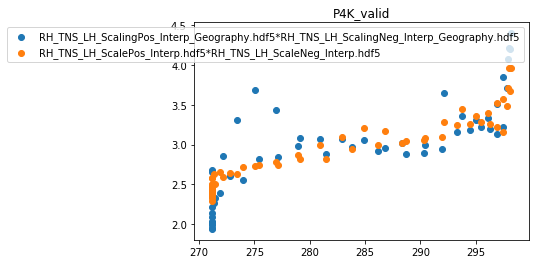

In [45]:
for i,NNs in enumerate(NNarray):
    plt.scatter(np.mean(coor.TS,axis=(0,2)),np.log10(np.mean(MSE[NNs][data[6:-3]],axis=1)),label=NNs)
plt.legend()
plt.title(data[6:-3])

Text(0.5, 1.0, 'P4K_valid')

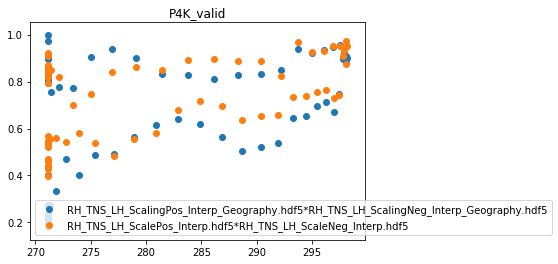

In [46]:
for i,NNs in enumerate(NNarray):
    plt.scatter(np.mean(coor.TS,axis=(0,2)),np.mean(MSE[NNs][data[6:-3]],axis=1)/
                np.mean(VAR[NNs][data[6:-3]],axis=1),label=NNs)
plt.legend()
plt.title(data[6:-3])

In [46]:
MSE

{'samples': 20,
 'RH_TNS_LH_ScalingPos_Interp_Geography.hdf5*RH_TNS_LH_ScalingNeg_Interp_Geography.hdf5': 715.081431196014,
 'RH_TNS_LH_ScalePos_Interp.hdf5*RH_TNS_LH_ScaleNeg_Interp.hdf5': 650.9503243758248}

In [40]:
data

'CI_SP_P4K_valid.nc'

In [ ]:
lat_ind = np.arange(0,64)
iinis = [500]

# diagno = {} # Diagnostics structure
# diagno['truth'] = {} # Diagnostics structure for the truth
# diagno['truth_pos'] = {} # Diagnostics structure for the truth pos
# diagno['truth_neg'] = {} # Diagnostics structure for the truth neg
# truth_done = {}

# for j,data in enumerate(data_file):
#     truth_done[data[6:-3]] = False

for i,NNs in enumerate(NNarray):
    print('i=',i,'& NNs=',NNs,'         ')
    diagno[NNs] = {} # Diagnostics structure for each NN
    for j,data in enumerate(data_file):
        diagno[NNs][data[6:-3]]={}
        if i==0: 
#             diagno['truth'][data[6:-3]]={}
#             diagno['truth_pos'][data[6:-3]]={}
#             diagno['truth_neg'][data[6:-3]]={}
        for iini in iinis:
            
            print('j=',j,'& iini=',iini,'& data=',data,'         ',end='\r'),
            
            iend = iini+47
            diagno[NNs][data[6:-3]][iini] = {} # Diagnostics structure for each data file
            if i==0: 
                diagno['truth'][data[6:-3]][iini] = {}
                diagno['truth_pos'][data[6:-3]][iini] = {}
                diagno['truth_neg'][data[6:-3]][iini] = {}
                
            for itime in tqdm(np.arange(iini,iend)):
                # Get input, prediction and truth from NN
                inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
                ## only if the scaling is true
                if NN[NNs].scaling==True:
                    X, _ = md[NNs][data[6:-3]].valid_gen[itime]
                    mask, pos_op, neg_op = md[NNs][data[6:-3]].model.predict_on_batch_seperate(X.values)
                    mask_reshaped = md[NNs][data[6:-3]].reshape_ngeo(mask)[lat_ind,:,:]
                    mask = mask_reshaped.flatten()
                    neg_mask = np.logical_not(mask)
                    ## get the truth only once.
                p = np.array(p)
                # Get convective heating and moistening for each NN
                if itime==iini:
                    if i==0:
                        diagno['truth'][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                        diagno['truth'][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                    ##if scaling is true and the truth array is not filled
                    if NN[NNs].scaling==True and truth_done[data[6:-3]]==False:
                        diagno['truth_pos'][data[6:-3]][iini]['PHQ_pos'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno['truth_pos'][data[6:-3]][iini]['TPHYSTND_pos'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno['truth_neg'][data[6:-3]][iini]['PHQ_neg'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]
                        diagno['truth_neg'][data[6:-3]][iini]['TPHYSTND_neg'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]
                        truth_done[data[6:-3]] = True
                                                    
                    diagno[NNs][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                    diagno[NNs][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                    if NN[NNs].scaling==True:
                        diagno[NNs][data[6:-3]][iini]['PHQ_pos'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno[NNs][data[6:-3]][iini]['TPHYSTND_pos'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno[NNs][data[6:-3]][iini]['PHQ_neg'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]
                        diagno[NNs][data[6:-3]][iini]['TPHYSTND_neg'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]

                else:
                    for istr,field in enumerate(['PHQ','TPHYSTND']):
                        if field=='PHQ': ind_field = PHQ_idx
                        elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                        diagno[NNs][data[6:-3]][iini][field] = np.concatenate((diagno[NNs][data[6:-3]][iini][field],
                                                             md[NNs][data[6:-3]].\
                                                             reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                            axis=3)
                        if NN[NNs].scaling==True:
                            diagno[NNs][data[6:-3]][iini][field+'_pos'] = np.concatenate((diagno[NNs][data[6:-3]][iini][field+'_pos'],
                                         md[NNs][data[6:-3]].\
                                         reshape_ngeo(p[:,ind_field])[lat_ind,:,:].reshape(-1,30)[mask]),
                                        axis=0)

                            diagno[NNs][data[6:-3]][iini][field+'_neg'] = np.concatenate((diagno[NNs][data[6:-3]][iini][field+'_neg'],
                                         md[NNs][data[6:-3]].\
                                         reshape_ngeo(p[:,ind_field])[lat_ind,:,:].reshape(-1,30)[neg_mask]),
                                        axis=0)
                        if i==0:
                            diagno['truth'][data[6:-3]][iini][field] = np.concatenate((diagno['truth'][data[6:-3]][iini][field],
                                                                     md[NNs][data[6:-3]].\
                                                                     reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                    axis=3)
                            
                            if NN[NNs].scaling==True:
                                diagno['truth_pos'][data[6:-3]][iini][field+'_pos'] = np.concatenate((diagno['truth_pos'][data[6:-3]][iini][field+'_pos'],
                                             md[NNs][data[6:-3]].\
                                             reshape_ngeo(truth[:,ind_field])[lat_ind,:,:].reshape(-1,30)[mask]),
                                            axis=0)
                                diagno['truth_neg'][data[6:-3]][iini][field+'_neg'] = np.concatenate((diagno['truth_neg'][data[6:-3]][iini][field+'_neg'],
                                         md[NNs][data[6:-3]].\
                                         reshape_ngeo(truth[:,ind_field])[lat_ind,:,:].reshape(-1,30)[neg_mask]),
                                        axis=0)